# Training a MLP using forward AD and different sampler
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DSSC-projects/veni/blob/main/examples/example3.ipynb))


In the following tutorial we see how to sample directions differently when estimating the gradient using `veni.optim.grad_fwd()`. Theoretically, the loss should go down approximately the same using different directions. However, we will notice from this tutorial that sometimes using a different sample method may lead to an improvement in performance with less epochs performed.

As in `example2` we import the useful modules and we define our MLP model

In [1]:
from torchvision.datasets import MNIST
import numpy as np
import sys

sys.path.append('../')

import jax

jax.config.update('jax_platform_name','cpu')
import matplotlib.pyplot as plt
from jax import grad
from veni.net import Module, Sequential, Linear
from veni.function import Softmax, ReLU
from veni.utils import one_hot, NumpyLoader
from veni.functiontools import CrossEntropy
from veni.optim import Adam, grad_fwd, RademacherLikeSampler, TruncatedNormalLikeSampler, NormalLikeSampler
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm



key = jax.random.PRNGKey(10)
batch_size = 64

#flatten and normalize
class tf(object):
    def __call__(self, pic):
        return ( np.ravel(np.array(pic, dtype=jnp.float32)) / 255. - 0.5 ) * 2

training_dataset = MNIST('/tmp/mnist/', train = True, download= True, transform= tf())
training_generator = NumpyLoader(training_dataset, batch_size= batch_size )


testing_dataset = MNIST('/tmp/mnist/', train = False,download= True, transform= tf() )
testing_generator = NumpyLoader(testing_dataset, batch_size= batch_size )

Making model: MLP for MNIST classification. 
Optimizer: Adam optimizer

In [2]:
class MLP(Module):
    def __init__(self):
        self.layers = Sequential([
            Linear(28*28, 1024, jax.random.PRNGKey(10)),
            ReLU(),
            Linear(1024, 1024, key),
            ReLU(),
            Linear(1024, 10, key),
            Softmax()
        ])

        self.params = self.layers.generate_parameters()
        #eliminate the bias
    
    def forward(self,x,params):
        return self.layers(x,params)

Some useful functions

In [3]:
def loss(params, x, y):
    y_hat = model(x, params)
    return CrossEntropy(y, y_hat)

def accuracy(y,y_hat):
    model_predictions = jnp.argmax(y_hat, axis= 1)
    return jnp.mean(y == model_predictions)

def grad_bwd(params, x, y, loss, key):
    grads = grad(loss)(params, x, y)
    return grads

def update(params, x, y, loss, optimizer, key, grad_type = 'fwd', sampler = None):
    key = jax.random.split(key)
    if grad_type == 'fwd':
        if sampler is None:
            grads = grad_fwd(params, x, y, loss, 1)
        else:
            grads = grad_fwd(params, x, y, loss, 1, sampler)
    elif grad_type == 'bwd':
        grads = grad_bwd(params, x, y, loss, key)
    else:
        raise ValueError(f"Invalid grad_type, expected 'fwd' or 'bwd' got {grad_type}")

    return optimizer(params, grads)

The `grad_fwd()` function can take a sampler as an input. A sampler is an object which specifies how to sample the random direciton for forward ad gradient estimate. The sampler must have zero mean and unit variance. Currently available sampler are: `NormalLikeSampler()` (default), `RademacherLikeSampler()` and `TruncatedNormalLikeSampler()`. We will investigate how they behave.

In [4]:
model = MLP()
params = model.params
optimizer = Adam(params, eta=0.0005)

res_loss1 = []
res_iter1 = []
count=0
for epoch in tqdm(range(5)):
    running_loss = 0
    for i, (x, y) in enumerate(training_generator):
        key = jax.random.split(key)
        one_hot_label = one_hot(y, 10)
        running_loss += loss(params, x, one_hot_label)
        params = update(params, x, one_hot_label, loss, optimizer, key, grad_type='fwd', sampler = NormalLikeSampler())
        count+=1
        if i%100 == 99:
            res_loss1.append(running_loss/100)
            res_iter1.append(count)
            running_loss = 0

100%|██████████| 5/5 [05:20<00:00, 64.07s/it]


In [5]:
model = MLP()
params = model.params
optimizer = Adam(params, eta=0.0005)

res_loss2 = []
res_iter2 = []
count=0
for epoch in tqdm(range(5)):
    running_loss = 0
    for i, (x, y) in enumerate(training_generator):
        key = jax.random.split(key)
        one_hot_label = one_hot(y, 10)
        running_loss += loss(params, x, one_hot_label)
        params = update(params, x, one_hot_label, loss, optimizer, key, grad_type='fwd', sampler = RademacherLikeSampler())
        count+=1
        if i%100 == 99:
            res_loss2.append(running_loss/100)
            res_iter2.append(count)
            running_loss = 0

100%|██████████| 5/5 [07:24<00:00, 88.86s/it]


In [6]:
model = MLP()
params = model.params
optimizer = Adam(params, eta=0.0005)

res_loss3 = []
res_iter3 = []
count=0
for epoch in tqdm(range(5)):
    running_loss = 0
    for i, (x, y) in enumerate(training_generator):
        key = jax.random.split(key)
        one_hot_label = one_hot(y, 10)
        running_loss += loss(params, x, one_hot_label)
        params = update(params, x, one_hot_label, loss, optimizer, key, grad_type='fwd', sampler = TruncatedNormalLikeSampler())
        count+=1
        if i%100 == 99:
            res_loss3.append(running_loss/100)
            res_iter3.append(count)
            running_loss = 0

100%|██████████| 5/5 [06:48<00:00, 81.79s/it]


Let's plot the result

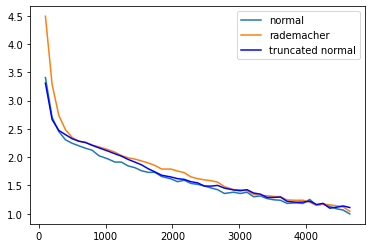

In [7]:

plt.plot(res_iter1[-80:], res_loss1[-80:], label = 'normal')
plt.plot(res_iter2[-80:], res_loss2[-80:], label = 'rademacher')
plt.plot(res_iter3[-80:], res_loss3[-80:], label = 'truncated normal', c = 'b')
plt.legend()
plt.show()

As we can see from the above plot, the truncated normal [-1, 1] sampler tends to perform similarly to the normal samples, whule the rademacher sampler tends to be a bit worst. However, in general we can see that if the mean is 0 and the variance is 1 the type of distrubution seems not to change the behaviour of the gradient estimate